In [1]:
import torch
import torch.nn as nn
import torchvision
from torch.nn import Module
from torchvision import datasets, models, transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
# Customized CNN model
class Net(Module):   
    def __init__(self, pretrained = False):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv2 = nn.Conv2d(64, 64, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv3 = nn.Conv2d(64, 128, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv4 = nn.Conv2d(128, 128, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv5 = nn.Conv2d(128, 256, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv6 = nn.Conv2d(256, 256, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv7 = nn.Conv2d(256, 256, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv8 = nn.Conv2d(256, 512, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv9 = nn.Conv2d(512, 512, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv10 = nn.Conv2d(512, 512, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv11 = nn.Conv2d(512, 512, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv12 = nn.Conv2d(512, 512, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv13 = nn.Conv2d(512, 512, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.fc1 = nn.Linear(4 * 4 * 512, 512)
        self.dropout = nn.Dropout(p = 0.3)
#         self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 1)
    
    def lock_base(self):
        for parameter in self.parameters():
            parameter.requires_grad = False
        self.fc1.weight.requires_grad = True
        self.fc1.bias.requires_grad = True
#         self.fc2.weight.requires_grad = True
#         self.fc2.bias.requires_grad = True
        self.fc3.weight.requires_grad = True
        self.fc3.bias.requires_grad = True
    
    def unlock_base(self):
        for parameter in self.parameters():
            parameter.requires_grad = True
            
    def load_pretrained(self):
        print("Loading weights and bias from VGG16.")
        vgg16 = torchvision.models.vgg16(pretrained = True)
        self.conv1.weight.data = vgg16.features[0].weight.data.to(device = device)
        self.conv1.bias.data = vgg16.features[0].bias.data.to(device = device)
        self.conv2.weight.data = vgg16.features[2].weight.data.to(device = device)
        self.conv2.bias.data = vgg16.features[2].bias.data.to(device = device)
        self.conv3.weight.data = vgg16.features[5].weight.data.to(device = device)
        self.conv3.bias.data = vgg16.features[5].bias.data.to(device = device)
        self.conv4.weight.data = vgg16.features[7].weight.data.to(device = device)
        self.conv4.bias.data = vgg16.features[7].bias.data.to(device = device)
        self.conv5.weight.data = vgg16.features[10].weight.data.to(device = device)
        self.conv5.bias.data = vgg16.features[10].bias.data.to(device = device)
        self.conv6.weight.data = vgg16.features[12].weight.data.to(device = device)
        self.conv6.bias.data = vgg16.features[12].bias.data.to(device = device)
        self.conv7.weight.data = vgg16.features[14].weight.data.to(device = device)
        self.conv7.bias.data = vgg16.features[14].bias.data.to(device = device)
        self.conv8.weight.data = vgg16.features[17].weight.data.to(device = device)
        self.conv8.bias.data = vgg16.features[17].bias.data.to(device = device)
        self.conv9.weight.data = vgg16.features[19].weight.data.to(device = device)
        self.conv9.bias.data = vgg16.features[19].bias.data.to(device = device)
        self.conv10.weight.data = vgg16.features[21].weight.data.to(device = device)
        self.conv10.bias.data = vgg16.features[21].bias.data.to(device = device)
        self.conv11.weight.data = vgg16.features[24].weight.data.to(device = device)
        self.conv11.bias.data = vgg16.features[24].bias.data.to(device = device)
        self.conv12.weight.data = vgg16.features[26].weight.data.to(device = device)
        self.conv12.bias.data = vgg16.features[26].bias.data.to(device = device)
        self.conv13.weight.data = vgg16.features[28].weight.data.to(device = device)
        self.conv13.bias.data = vgg16.features[28].bias.data.to(device = device)
    
    # Defining the forward pass    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv8(x))
        x = F.relu(self.conv9(x))
        x = F.relu(self.conv10(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        x = F.relu(self.conv13(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [4]:
# prepare the training data
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm

In [5]:
input_path = '/home/chenyu/Desktop/CNNmeasurement/TrainingData_CoarseCNN/'
train_data = np.load(input_path + 'FullRandom_40mrad_highCs_3fold_C5negC1_C3negC1_whiteNoise_32pxGaussian_multiNoise_30pA_128pxRonch_x25000.npy')
print(train_data.shape)

train_label = np.load(input_path + 'FullRandom_40mrad_highCs_3fold_C5negC1_C3negC1_whiteNoise_32pxGaussian_multiNoise_30pA_newEmit_x25000.npy')
train_label_1 = (train_label - np.amin(train_label))/(np.amax(train_label) - np.amin(train_label))
print(train_label.shape)

train_label = np.load(input_path + 'FullRandom_40mrad_highCs_3fold_C5negC1_C3negC1_whiteNoise_32pxGaussian_multiNoise_30pA_defocus_x25000.npy')
train_label_2 = (train_label - np.amin(train_label))/(np.amax(train_label) - np.amin(train_label))
print(train_label.shape)

train_label = (train_label_1 + train_label_2) / 2

(25002, 128, 128)
(25002,)
(25002,)


In [6]:
def scale_range (input, min, max):
    input += -(np.min(input))
    input /= np.max(input) / (max - min)
    input += min
    return input    

In [7]:
class RonchigramDataset(Dataset):
    def __init__(self, data, labels, transform = None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        img = scale_range(self.data[index,:,:].astype('float'), 0, 1)
        new_channel = np.zeros(img.shape)
        img = np.dstack((img, new_channel, new_channel))
        img = Image.fromarray(np.uint8(img*255))
        y_label = torch.tensor(float(self.labels[index]))

        if self.transform is not None:
            img = self.transform(img)

        return (img, y_label)

In [8]:
transform = transforms.Compose(
        [
            transforms.Resize((135, 135)),
            transforms.RandomResizedCrop((128, 128), scale = (0.9, 1.0), ratio = (0.97, 1.03)),
            transforms.ToTensor(),
            # TODO: need to add random shear here
            # option to normalize a tensor with mean and standard deviation, similar to featurewise center in Keras
#             transforms.Normalize((1.0, 1.0, 1.0), (1.0, 1.0, 1.0)),
        ]
    )

In [9]:
# training hyperparameters
num_epochs = 20
learning_rate = 1e-3
train_CNN = False
batch_size = 32
shuffle = True
pin_memory = True
num_workers = 1

In [10]:
dataset = RonchigramDataset(train_data, train_label, transform = transform)

train_set, validation_set = torch.utils.data.random_split(dataset,[20000,5002])

train_loader = DataLoader(dataset=train_set, shuffle=shuffle, batch_size=batch_size,num_workers=num_workers,pin_memory=pin_memory)

validation_loader = DataLoader(dataset=validation_set, shuffle=shuffle, batch_size=batch_size,num_workers=num_workers, pin_memory=pin_memory)

In [11]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

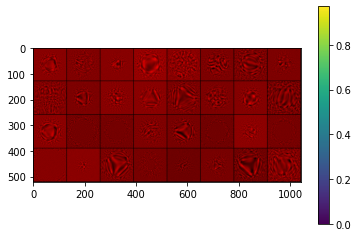

In [12]:
def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.colorbar()
    plt.show()
    
imshow(torchvision.utils.make_grid(images))

In [13]:
# Call the CNN model and start training
model = Net().to(device)
model.load_pretrained()
model.lock_base()
criterion = nn.MSELoss(reduction = 'mean')

Loading weights and bias from VGG16.


In [14]:
def check_accuracy(loader, model):
    if loader == train_loader:
        print("Checking accuracy on training data")
    else:
        print("Checking accuracy on validation data")

    sum_MSE = 0
    counter = 0
    loss = nn.MSELoss(reduction = 'mean')
    model.eval()

    y_list = torch.empty(0).to(device = device)
    pred_list = torch.empty(0).to(device = device)

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            pred = torch.squeeze(model(x))
            pred_list = torch.cat((pred_list, pred), 0)
            y_list = torch.cat((y_list, y), 0)
            sum_MSE += loss(pred, y)
            counter += 1
    
    fig, ax = plt.subplots(1,1, figsize = (5,5))
    img = ax.scatter(y_list.cpu().numpy(), pred_list.cpu().numpy(), s = 1)
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.plot(np.linspace(0,1,100), np.linspace(0,1,100),'--', c = 'red')
    ax.tick_params(axis='both', labelsize=16)
    ax.set_xlabel('Truth',fontsize = 16)
    ax.set_ylabel('Prediction', fontsize = 16)
    plt.show()
    
    model.train()
            
    return f"{float(sum_MSE)/float(counter):.4f}"
    print(
            f"Got accuracy {float(sum_MSE)/float(counter):.4f}"
        )
#     model.train()

In [ ]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [15]:
def train():
    early_stopping = EarlyStopping(patience = 5, min_delta = 1e-4)
    model.train()
    for epoch in range(num_epochs):
        loop = tqdm(train_loader, total = len(train_loader), leave = True)
        if epoch % 2 == 0:
            val_acc = check_accuracy(validation_loader, model)
            loop.set_postfix(val_acc = val_acc)
            early_stopping(val_acc)
            if early_stopping.early_stop:
                break
        for imgs, labels in loop:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = torch.squeeze(model(imgs))
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loop.set_description(f"Epoch [{epoch}/{num_epochs}]")
            loop.set_postfix(loss = loss.item())

  0%|                                                                                                                                                                                                                                                     | 0/625 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


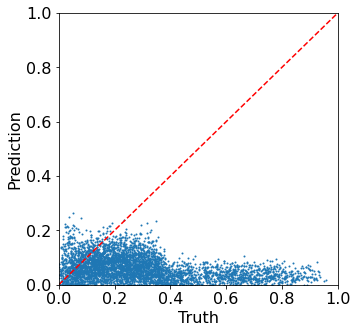

  0%|                                                                                                                                                                                                                                                     | 0/625 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


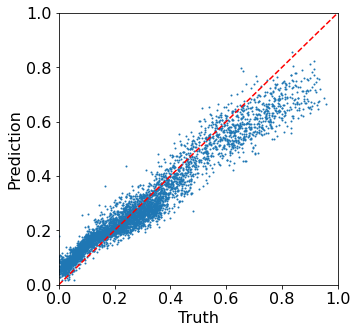

  0%|                                                                                                                                                                                                                                                     | 0/625 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


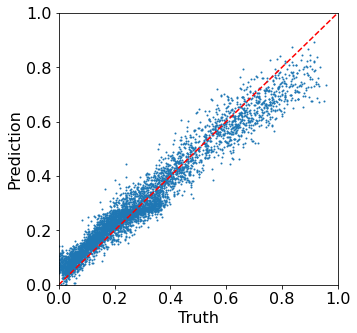

  0%|                                                                                                                                                                                                                                                     | 0/625 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


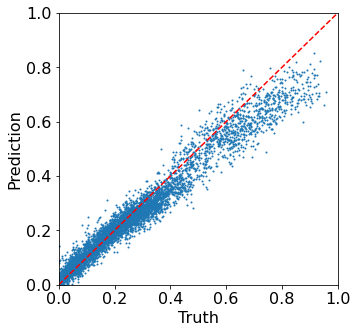

  0%|                                                                                                                                                                                                                                                     | 0/625 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


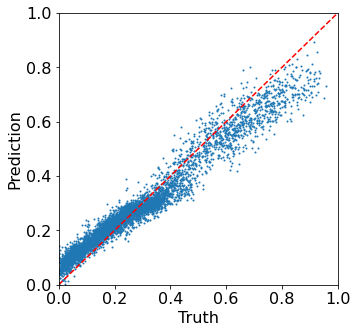

  0%|                                                                                                                                                                                                                                                     | 0/625 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


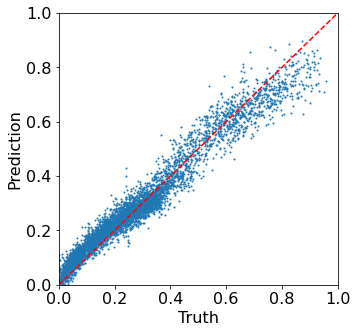

  0%|                                                                                                                                                                                                                                                     | 0/625 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


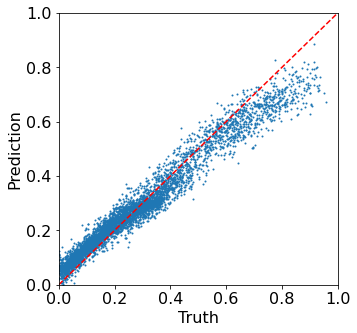

  0%|                                                                                                                                                                                                                                                     | 0/625 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


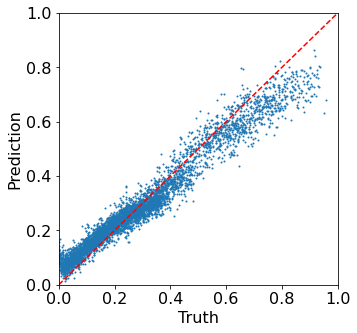

  0%|                                                                                                                                                                                                                                                     | 0/625 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


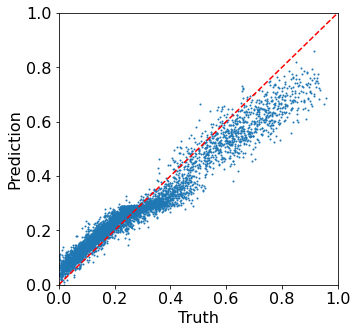

  0%|                                                                                                                                                                                                                                                     | 0/625 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


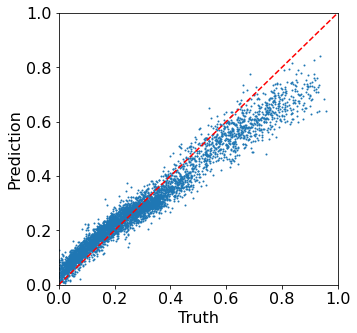

Epoch [19/20]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [00:35<00:00, 17.39it/s, loss=0.00636]


In [16]:
learning_rate = 1e-4
num_epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps = 1e-07)
train()

  0%|                                                                                                                                                                                                                                                     | 0/625 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


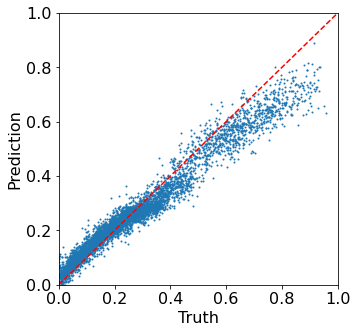

  0%|                                                                                                                                                                                                                                                     | 0/625 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


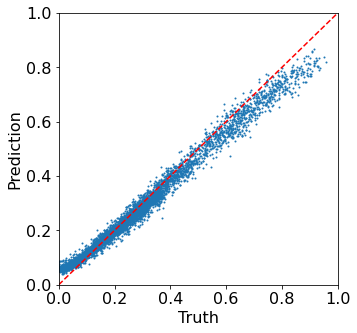

  0%|                                                                                                                                                                                                                                                     | 0/625 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


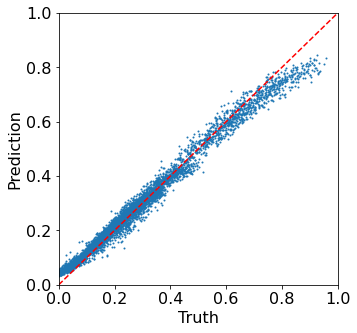

  0%|                                                                                                                                                                                                                                                     | 0/625 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


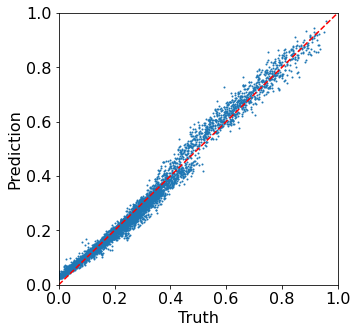

  0%|                                                                                                                                                                                                                                                     | 0/625 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


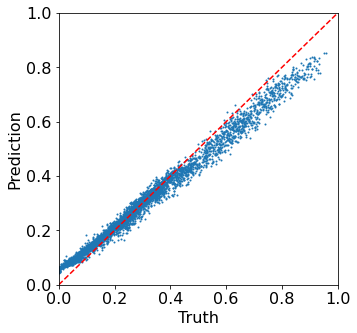

  0%|                                                                                                                                                                                                                                                     | 0/625 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


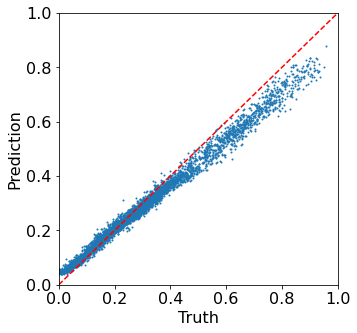

  0%|                                                                                                                                                                                                                                                     | 0/625 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


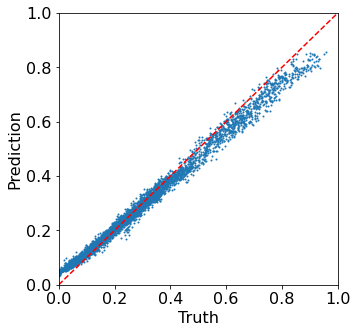

  0%|                                                                                                                                                                                                                                                     | 0/625 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


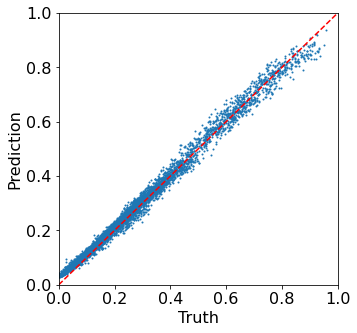

  0%|                                                                                                                                                                                                                                                     | 0/625 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


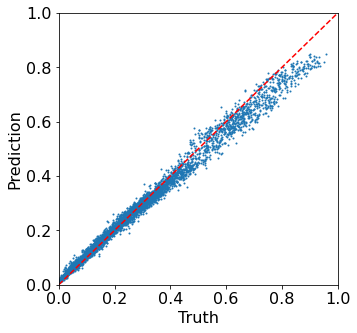

  0%|                                                                                                                                                                                                                                                     | 0/625 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


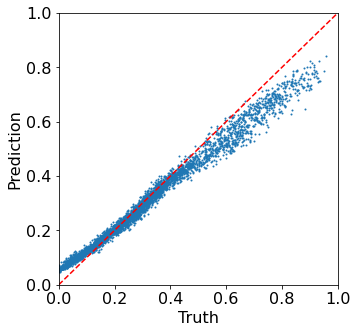

  0%|                                                                                                                                                                                                                                                     | 0/625 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


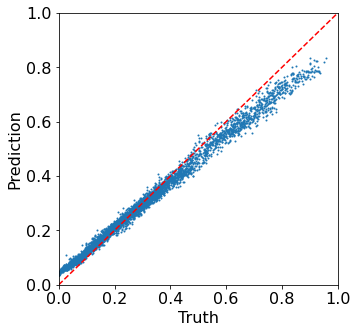

  0%|                                                                                                                                                                                                                                                     | 0/625 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


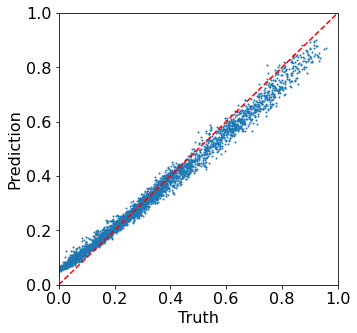

Epoch [23/50]:  12%|█████████████████████████▊                                                                                                                                                                                     | 78/625 [00:16<01:59,  4.60it/s, loss=0.00807]


KeyboardInterrupt: 

In [17]:
model.unlock_base()
num_epochs = 50
learning_rate = 5.5e-5
train_CNN = False
batch_size = 32
shuffle = True
pin_memory = True
num_workers = 1

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps = 1e-07)

train()

In [ ]:
print(outputs.shape)
print(labels.shape)
print(criterion(torch.squeeze(outputs).to(device), labels.to(device)))

In [ ]:
loss = nn.MSELoss()
input = torch.randn(5, requires_grad=True)
target = torch.randn(5)
input_2 = input.unsqueeze(-1)
output = loss(input_2, target)
print(output)
output = loss(input, target)
print(output)
print(input)
print(target)